<a href="https://colab.research.google.com/github/jnpos/group8_ECG/blob/main/ECG_group8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Experimental set-up**

## **Load data and packages**

In [1]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Packages
import numpy as np 
from sklearn import preprocessing
from scipy.stats import shapiro
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve, train_test_split, StratifiedKFold, cross_val_score




Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 67.99 MiB | 11.60 MiB/s, done.
The number of samples: 827
The number of columns: 9001


## **Split data into input and output**

In [2]:
# Find column with label 
bool_cols = [col for col in data 
             if np.isin(data[col].dropna().unique(), [0, 1]).all()]
loc_label = data.columns.get_loc('label')

# Determine data and output 
y = data['label']
x = pd.DataFrame()
x = data.drop(data.columns[loc_label],axis=1)

## **Preprocessing**

**Delete samples with missing data**

In [3]:
deleted_patients = []
zero_samples = []
zero_counts = []

# Find patients (samples) with zero-padded ECG lead(s) (number of zeros for 1 lead = 750)
for i in range(len(x)):
  num_zeros = (x.iloc[i] == 0).sum()
  if (num_zeros/750 >= 1) & (num_zeros%750 == 0):      # control if number of zeros is divisible by 750 and therefore zero-padded missing data and not relevant actual data
    deleted_patients.append(i)
    zero_samples.append("Sample_" + str(i))
    zero_counts.append(num_zeros)

# Delete patients with missing lead data from dataset
x_dropped = x.drop(deleted_patients)
x_dropped = x_dropped.reset_index(drop=True)
y_dropped = y.drop(deleted_patients)
y_dropped = y_dropped.reset_index(drop=True)
table = pd.DataFrame({'Sample ID': zero_samples, 'Zero count': zero_counts})

# Return table from patients that were deleted and give resultant number of samples and columns in final dataset
print(f'The number of samples: {len(x_dropped.index)}')
print(f'The number of samples dropped: {len(table)}')

The number of samples: 813
The number of samples dropped: 14


**Split data in train and test set**

In [4]:
# Split test and trainingsdata and print shape of resulting trainset
x_train, x_test, y_train, y_test = train_test_split(x_dropped, y_dropped, test_size=0.25,random_state=0,stratify=y_dropped)
y_testtest = pd.DataFrame(y_test).reset_index()
del y_testtest[y_testtest.columns[0]]

x_testtest = pd.DataFrame(x_test).reset_index()
del x_testtest[x_testtest.columns[0]]


print(f'Shape of training set x_train: {x_train.shape}')

Shape of training set x_train: (609, 9000)


**Scaling**

In [5]:
# Scaling fit and transform x_train, only transform x_test; 
scaler = preprocessing.RobustScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))

**Test if data is normally distributed**

In [83]:
# Checking if data is normally distributed and print result 
amount_normallydistributed = 0

for column in x_train.columns:
  result = shapiro(x_train[column])
  normallydistributed = result.pvalue > 0.05
  amount_normallydistributed += normallydistributed 
  
print(amount_normallydistributed, "features are normally distributed features")

0 features are normally distributed features


## **Feature selection**

**Univariate**

In [8]:
# Apply univariate feature selection and print resulting shape of train dataset
selector = SelectKBest(f_classif, k="all")
selector.fit(x_train,y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

dataframe = pd.DataFrame()
dataframe = selector.pvalues_

fs = SelectKBest(score_func=f_classif, k=len(selector.pvalues_[selector.pvalues_<0.05]))
X_univariate = fs.fit_transform(x_train, y_train)
print(f'Resulting x_train after univariate feature selection: {X_univariate.shape}')

Resulting x_train after univariate feature selection: (609, 855)


**Elastic Net (EN) regression**

In [6]:
# Apply elastic net regression feature selection and print resulting shape of train dataset
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=0)
regr = ElasticNetCV(alphas=[.001, 0.01, .1, .5, .7, .9, .95, 1], cv=skf, l1_ratio=[.001, 0.01, .1, .5, .7, .9, .95, 1], random_state=0,tol=1e-1)
regr.fit(x_train, y_train)
print(f'Tuned l1 ratio for elastic net regression: {regr.l1_ratio_}')
print(f'Tuned alpha for elastic net regression: {regr.alpha_}')

ENreg = ElasticNet(alpha=regr.alpha_, l1_ratio=regr.l1_ratio_).fit(x_train,y_train)
model_ENreg = SelectFromModel(ENreg, prefit=True)
X_ENreg = model_ENreg.transform(x_train)
print(f'Resulting x_train after EN regression feature selection: {X_ENreg.shape}')

Tuned l1 ratio for elastic net regression: 0.01
Tuned alpha for elastic net regression: 1.0
Resulting x_train after EN regression feature selection: (609, 648)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+00, tolerance: 8.820e-03
  model = cd_fast.enet_coordinate_descent(


## **Feature transformation**

**Principal Component Analysis (PCA)**

In [9]:
# In case of decision tree, feature amount is still too high after univariate feature selection
# Principal Component Analysis is therefore applied to reduce amount of features to smaller amount of components
X_univariate = pd.DataFrame(X_univariate)
n_samples = len(X_univariate)

p = PCA(n_components=n_samples//2)
X_pca_univariate = p.fit_transform(X_univariate)
print(f'Resulting x_train after univariate feature selection and PCA feature transformation: {X_pca_univariate.shape}')

X_pca_ENreg = p.fit_transform(X_ENreg)
print(f'Resulting x_train after univariate feature selection and PCA feature transformation: {X_pca_ENreg.shape}')


Resulting x_train after univariate feature selection and PCA feature transformation: (609, 304)
Resulting x_train after univariate feature selection and PCA feature transformation: (609, 304)


## **Plot learning curves for classifiers with default hyperparameter settings**

**Define performance metric**

In [10]:
# Define f_beta as a performance scorer
# Beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

**Classifiers in combination with univariate feature selection (+ PCA feature transformation for Decision Tree)**

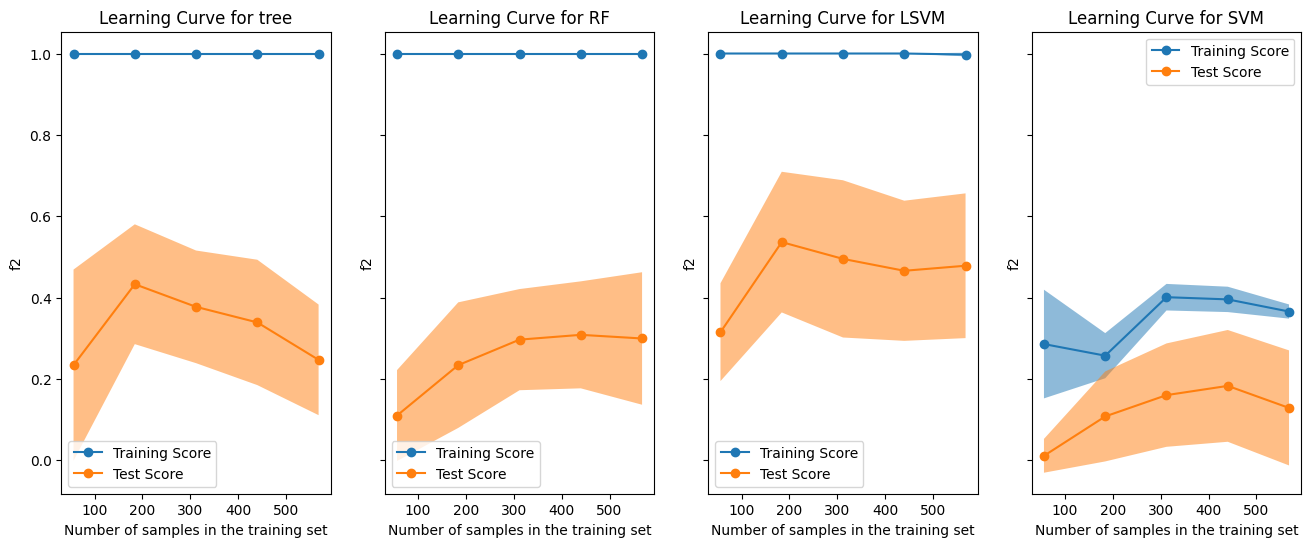

In [87]:
tree = DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

common_params_tree = {
    "X": X_pca_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

**Classifiers in combination with EN regression feature selection**



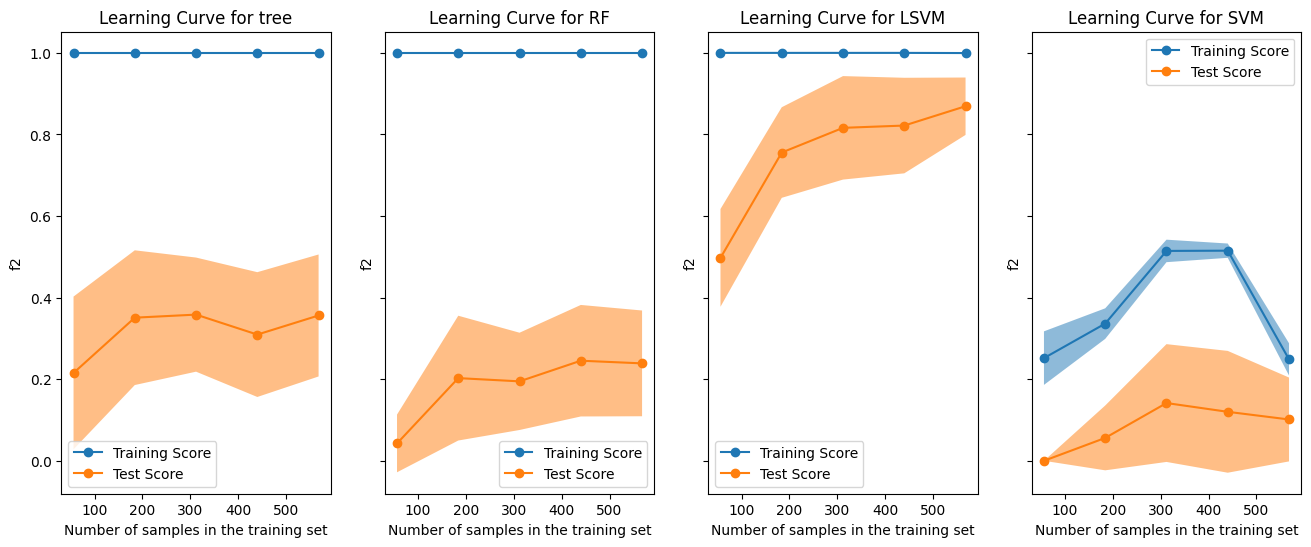

In [88]:
tree = DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0, dual=False)
svm = SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

common_params_tree = {
    "X": X_pca_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": skf,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

## **Optimize hyperparameter settings**

In [22]:
# Initialize classifiers
lsvm = LinearSVC(fit_intercept=True, class_weight='balanced', random_state=0)
tree = DecisionTreeClassifier(class_weight='balanced', random_state=0)
svm = SVC(class_weight='balanced', random_state=0)
RF = RandomForestClassifier(class_weight='balanced', random_state=0)

# Define distributions
distributions_lsvm = dict(penalty=['l2', 'l1'],
                     loss = ['hinge','squared_hinge'],                                       
                     tol = np.geomspace(1e-7, 1e2, num=4),
                     C = np.geomspace(1e-5, 1e5, num=4),
                     intercept_scaling = range(1,10,5),
                     )

distributions_tree = dict(criterion =['gini','entropy','log_loss'],
                     splitter=['best','random'],
                     min_samples_split=range(2,10),
                     min_samples_leaf=range(1,10),
                     min_weight_fraction_leaf = np.linspace(0, 0.5, 25),
                     max_features=['sqrt','log2',None],
                     )

distributions_svm = dict(C = np.geomspace(1e-5, 1e5, num=11),
                     kernel=['linear','poly','rbf','sigmoid'],
                     degree = range(0,5),
                     gamma=['scale','auto'],
                     coef0 = range(-5,5),
                     shrinking = [True,False],
                     probability = [True, False],
                     tol = np.geomspace(1e-7, 1e2, num=10),
                     cache_size=range(10,400),
                     )

distributions_rf = dict(n_estimators = range(5,1000,5),
                     criterion =['gini','entropy','log_loss'],
                     min_samples_split=range(2,10,5),
                     min_samples_leaf=range(1,10,5),
                     min_weight_fraction_leaf = np.linspace(0, 0.5, 5),
                     max_features=['sqrt','log2',None],
                     bootstrap=[True,False],
                     oob_score=[True,False],
                     warm_start=[True,False],
                     )

# Perform Randomized Search 
clf_lsvm = RandomizedSearchCV(lsvm, distributions_lsvm, random_state=0, error_score=0.0, scoring=f_beta, n_iter=20) 
clf_tree = RandomizedSearchCV(tree, distributions_tree, random_state=0, error_score=0.0, scoring=f_beta, n_iter=20) 
clf_svm = RandomizedSearchCV(svm, distributions_svm, random_state=0, error_score=0.0, scoring=f_beta, n_iter=20)
clf_rf = RandomizedSearchCV(RF, distributions_rf, random_state=0, error_score=0.0, scoring=f_beta, n_iter=20) 


# Fit tuned parameters on x_ENreg/ X_univariate and y_train:
search_lsvm_univariate = clf_lsvm.fit(X_univariate, y_train) 
search_tree_univariate = clf_tree.fit(X_univariate, y_train)
search_svm_univariate = clf_svm.fit(X_univariate, y_train)
search_rf_univariate = clf_rf.fit(X_univariate, y_train)

print(f'best parameters for LSVM univariate {search_lsvm_univariate.best_params_}')
print(f'best parameters for Tree univariate {search_tree_univariate.best_params_}')
print(f'best parameters for SVM univariate {search_svm_univariate.best_params_}')
print(f'best parameters for RF univariate {search_rf_univariate.best_params_}')

# Fit tuned parameters on x_ENreg/ X_univariate and y_train:
search_lsvm_enreg  = clf_lsvm.fit(X_ENreg, y_train) 
search_tree_enreg = clf_tree.fit(X_ENreg, y_train)
search_svm_enreg = clf_svm.fit(X_ENreg, y_train)
search_rf_enreg = clf_rf.fit(X_ENreg, y_train)

print(f'best parameters for LSVM enreg {search_lsvm_enreg.best_params_}')
print(f'best parameters for Tree enreg {search_tree_enreg.best_params_}')
print(f'best parameters for SVM enreg {search_svm_enreg.best_params_}')
print(f'best parameters for RF enreg {search_rf_enreg.best_params_}')

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

best parameters for LSVM univariate {'tol': 1e-07, 'penalty': 'l2', 'loss': 'squared_hinge', 'intercept_scaling': 6, 'C': 1e-05}
best parameters for Tree univariate {'splitter': 'best', 'min_weight_fraction_leaf': 0.08333333333333333, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'log_loss'}
best parameters for SVM univariate {'tol': 1.0, 'shrinking': True, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 4, 'cache_size': 169, 'C': 0.001}
best parameters for RF univariate {'warm_start': False, 'oob_score': False, 'n_estimators': 350, 'min_weight_fraction_leaf': 0.125, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

best parameters for LSVM enreg {'tol': 1e-07, 'penalty': 'l2', 'loss': 'squared_hinge', 'intercept_scaling': 1, 'C': 0.021544346900318846}
best parameters for Tree enreg {'splitter': 'random', 'min_weight_fraction_leaf': 0.0625, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'entropy'}
best parameters for SVM enreg {'tol': 1.0, 'shrinking': True, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 4, 'cache_size': 169, 'C': 0.001}
best parameters for RF enreg {'warm_start': False, 'oob_score': False, 'n_estimators': 510, 'min_weight_fraction_leaf': 0.375, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}


### ***Weghalen als we de code inleveren***

In [11]:
search_lsvm_univariate_best_params_ = {'tol': 1e-07, 'penalty': 'l2', 'loss': 'squared_hinge', 'intercept_scaling': 1, 'C': 0.021544346900318846}
search_tree_univariate_best_params_ = {'splitter': 'random', 'min_weight_fraction_leaf': 0.0625, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'entropy'}
search_svm_univariate_best_params_ = {'tol': 1.0, 'shrinking': True, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 4, 'cache_size': 169, 'C': 0.001}
search_rf_univariate_best_params_ = {'warm_start': False, 'oob_score': False, 'n_estimators': 350, 'min_weight_fraction_leaf': 0.125, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}

search_lsvm_enreg_best_params_ = {'tol': 1e-07, 'penalty': 'l2', 'loss': 'squared_hinge', 'intercept_scaling': 1, 'C': 0.021544346900318846}
search_tree_enreg_best_params_ = {'splitter': 'random', 'min_weight_fraction_leaf': 0.0625, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'entropy'}
search_svm_enreg_best_params_ = {'tol': 1.0, 'shrinking': True, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 4, 'cache_size': 169, 'C': 0.001}
search_rf_enreg_best_params_ = {'warm_start': False, 'oob_score': False, 'n_estimators': 510, 'min_weight_fraction_leaf': 0.375, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}


## **Plot learning curves for classifiers with tuned hyperparameter settings**

**Classifiers in combination with univariate feature selection (+ PCA feature transformation for Decision Tree)** 

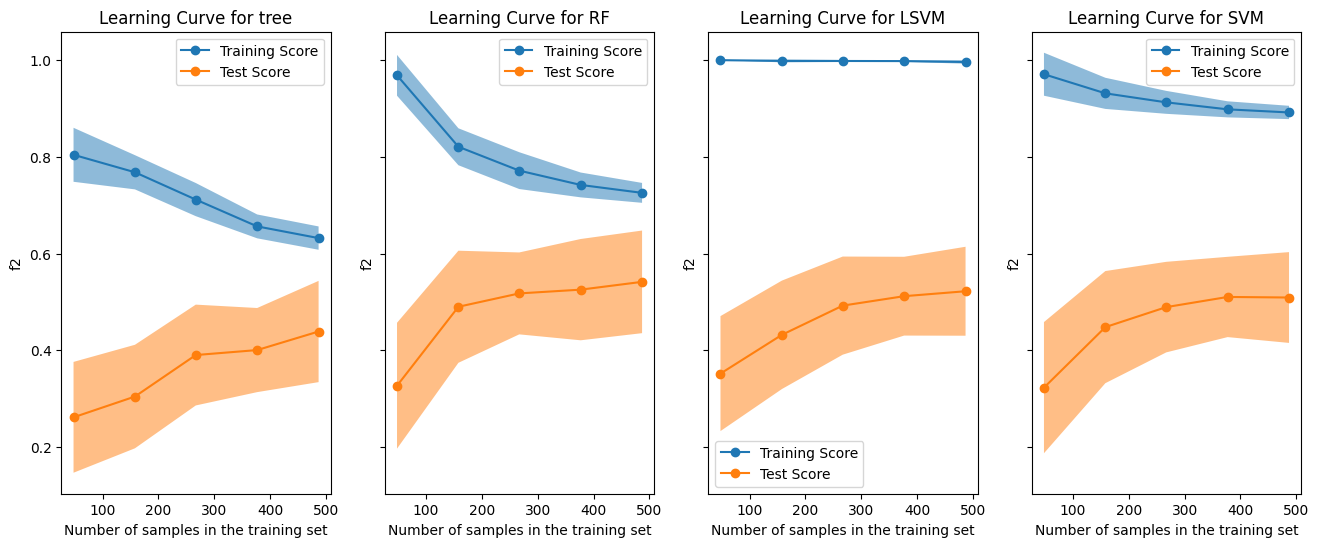

In [90]:
tree = DecisionTreeClassifier(**search_tree_univariate.best_params_,random_state=0, class_weight='balanced')
l_svm = LinearSVC(**search_lsvm_univariate.best_params_, random_state=0, fit_intercept=True, class_weight='balanced')
svm = SVC(**search_svm_univariate.best_params_, random_state=0, class_weight='balanced')
rf = RandomForestClassifier(**search_rf_univariate.best_params_, random_state=0, class_weight='balanced')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

common_params_tree = {
    "X": X_pca_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0], random_state=0)
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx], random_state=0)
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

**Classifiers in combination with EN regression feature selection**


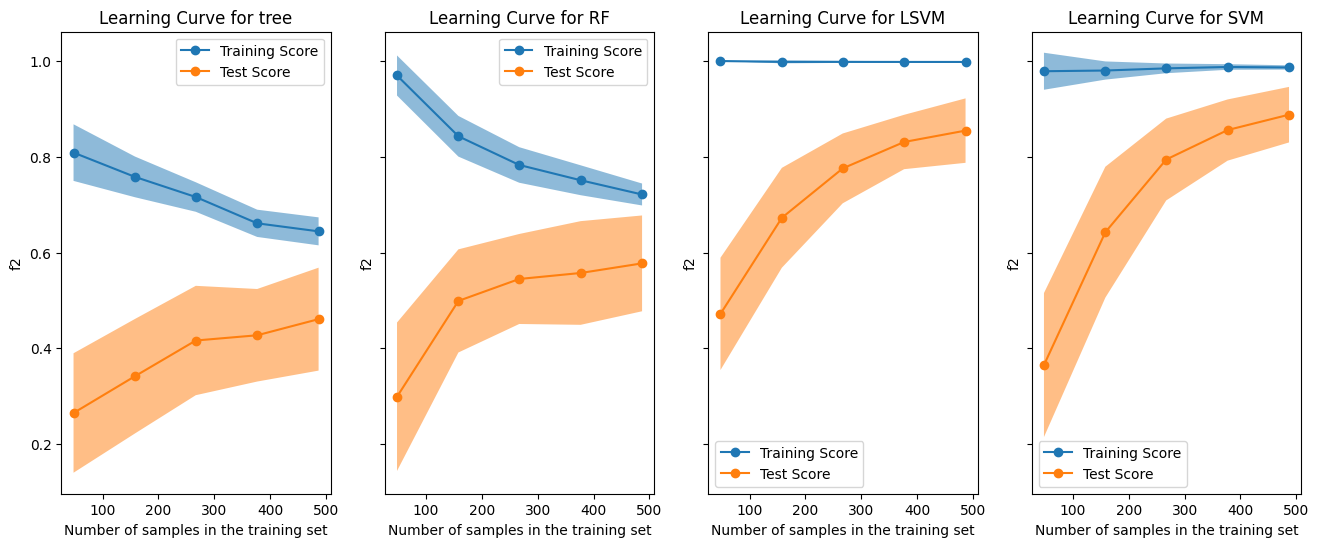

In [91]:
tree = DecisionTreeClassifier(**search_tree_enreg_best_params_,random_state=0, class_weight='balanced')
l_svm = LinearSVC(**search_lsvm_enreg.best_params_, random_state=0, fit_intercept=True, class_weight='balanced', dual=False)
svm = SVC(**search_svm_enreg_best_params_, random_state=0, class_weight='balanced')
rf = RandomForestClassifier(**search_rf_enreg_best_params_, random_state=0, class_weight='balanced')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

common_params_tree = {
    "X": X_pca_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0], random_state=0)
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx], random_state=0)
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")


## **Create tabels with f2 score and standard deviation:**


**Tables for not tuned hyperparameters**


In [92]:
tree = DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

common_params_univariate = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

common_params_tree_univariate = {
    "X": X_pca_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

# create a list of tuples containing classifier names and their instances
classifiers = [("Decision Tree", tree), ("Random Forest", rf), ("Linear SVM", l_svm), ("SVM", svm)]

# create an empty DataFrame to store the results
results_df_univariate = pd.DataFrame(columns=["Classifier", "Train Size", "Train Score", "Train Score Std", "Test Score", "Test Score Std"])

# loop through the classifiers
for clf_name, clf in classifiers:
    # set the name of the classifier in the results DataFrame
    results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)

    # select the common params based on the classifier name
    if clf_name == "Decision Tree":
        common_params_sel = common_params_tree_univariate
    else:
        common_params_sel = common_params_univariate
    
    # run the learning curve for the classifier
    train_size_abs, train_scores, test_scores = learning_curve(clf, **common_params_sel)

    # add the scores to the results DataFrame
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Size"] = train_size_abs[-1]
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Score"] = train_scores[-1, :].mean()
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Score Std"] = np.std(train_scores[-1, :])
    results_df_univariate.loc[len(results_df_univariate)-1, "Test Score"] = test_scores[-1, :].mean()
    results_df_univariate.loc[len(results_df_univariate)-1, "Test Score Std"] = np.std(test_scores[-1, :])

# print the results DataFrame
print(f'Results not tuned hyperparameters univariate')
print(results_df_univariate)

<ipython-input-92-01f1d96aed11>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-92-01f1d96aed11>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-92-01f1d96aed11>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train

Results not tuned hyperparameters univariate
      Classifier Train Size Train Score Train Score Std Test Score  \
0  Decision Tree        487         1.0             0.0   0.342493   
1  Random Forest        487         1.0             0.0   0.286854   
2     Linear SVM        487         1.0             0.0   0.495456   
3            SVM        487    0.355416        0.048355    0.15908   

  Test Score Std  
0       0.105187  
1       0.102553  
2       0.085852  
3        0.06666  


In [93]:
tree = DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

common_params_tree_enreg = {
    "X": X_pca_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

common_params_enreg = {
    "X": X_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}
# create a list of tuples containing classifier names and their instances
classifiers = [("Decision Tree", tree), ("Random Forest", rf), ("Linear SVM", l_svm), ("SVM", svm)]

results_df_enreg = pd.DataFrame(columns=["Classifier", "Train Size", "Train Score", "Train Score Std", "Test Score", "Test Score Std"])

# loop through the classifiers
for clf_name, clf in classifiers:
    # set the name of the classifier in the results DataFrame
    results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)

    # run the learning curve for the classifier
    if clf_name == "Decision Tree":
        common_params_sel = common_params_tree_enreg
    else:
        common_params_sel = common_params_enreg
    train_size_abs, train_scores, test_scores = learning_curve(clf, **common_params_sel)

    # add the scores to the results DataFrame
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Size"] = train_size_abs[-1]
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Score"] = train_scores[-1, :].mean()
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Score Std"] = np.std(train_scores[-1, :])
    results_df_enreg.loc[len(results_df_enreg)-1, "Test Score"] = test_scores[-1, :].mean()
    results_df_enreg.loc[len(results_df_enreg)-1, "Test Score Std"] = np.std(test_scores[-1, :])

print(f'Results not tuned hyperparameters enreg')
print(results_df_enreg)

<ipython-input-93-4932717c6101>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-93-4932717c6101>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-93-4932717c6101>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std":

Results not tuned hyperparameters enreg
      Classifier Train Size Train Score Train Score Std Test Score  \
0  Decision Tree        487         1.0             0.0   0.333144   
1  Random Forest        487         1.0             0.0   0.240669   
2     Linear SVM        487    0.998408        0.003744   0.845181   
3            SVM        487    0.252751        0.106124   0.084313   

  Test Score Std  
0       0.096563  
1       0.092578  
2       0.069556  
3       0.073468  


**Tables for tuned hyperparameters**


In [94]:
tree = DecisionTreeClassifier(**search_tree_enreg.best_params_,random_state=0, class_weight='balanced')
l_svm = LinearSVC(**search_lsvm_enreg.best_params_, random_state=0, class_weight='balanced', dual=False, fit_intercept=True)
svm = SVC(**search_svm_enreg.best_params_, random_state=0, class_weight='balanced')
rf = RandomForestClassifier(**search_rf_enreg.best_params_, random_state=0, class_weight='balanced')

common_params_univariate = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

common_params_tree_univariate = {
    "X": X_pca_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

# create a list of tuples containing classifier names and their instances
classifiers = [("Decision Tree", tree), ("Random Forest", rf), ("Linear SVM", l_svm), ("SVM", svm)]

# create an empty DataFrame to store the results
results_df_univariate = pd.DataFrame(columns=["Classifier", "Train Size", "Train Score", "Train Score Std", "Test Score", "Test Score Std"])

# loop through the classifiers
for clf_name, clf in classifiers:
    # set the name of the classifier in the results DataFrame
    results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)

    # select the common params based on the classifier name
    if clf_name == "Decision Tree":
        common_params_sel = common_params_tree_univariate
    else:
        common_params_sel = common_params_univariate
    
    # run the learning curve for the classifier
    train_size_abs, train_scores, test_scores = learning_curve(clf, **common_params_sel)

    # add the scores to the results DataFrame
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Size"] = train_size_abs[-1]
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Score"] = train_scores[-1, :].mean()
    results_df_univariate.loc[len(results_df_univariate)-1, "Train Score Std"] = np.std(train_scores[-1, :])
    results_df_univariate.loc[len(results_df_univariate)-1, "Test Score"] = test_scores[-1, :].mean()
    results_df_univariate.loc[len(results_df_univariate)-1, "Test Score Std"] = np.std(test_scores[-1, :])

# print the results DataFrame
print(f'Results tuned hyperparameters univariate')
print(results_df_univariate)

<ipython-input-94-9108ecc0aaad>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-94-9108ecc0aaad>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-94-9108ecc0aaad>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_univariate = results_df_univariate.append({"Classifier": clf_name, "Train Size": 0, "Train

Results tuned hyperparameters univariate
      Classifier Train Size Train Score Train Score Std Test Score  \
0  Decision Tree        487    0.632137        0.024105   0.439033   
1  Random Forest        487    0.725648        0.020571   0.541679   
2     Linear SVM        487    0.998081        0.000904    0.52021   
3            SVM        487    0.891888        0.013773   0.509305   

  Test Score Std  
0        0.10467  
1       0.106082  
2        0.08978  
3       0.093856  


In [95]:
tree = DecisionTreeClassifier(**search_tree_enreg.best_params_,random_state=0, class_weight='balanced')
l_svm = LinearSVC(**search_lsvm_enreg.best_params_, random_state=0, class_weight='balanced', dual=False, fit_intercept=True)
svm = SVC(**search_svm_enreg.best_params_, random_state=0, class_weight='balanced')
rf = RandomForestClassifier(**search_rf_enreg.best_params_, random_state=0, class_weight='balanced')


common_params_tree_enreg = {
    "X": X_pca_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}

common_params_enreg = {
    "X": X_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "scoring": f_beta
}
# create a list of tuples containing classifier names and their instances
classifiers = [("Decision Tree", tree), ("Random Forest", rf), ("Linear SVM", l_svm), ("SVM", svm)]

results_df_enreg = pd.DataFrame(columns=["Classifier", "Train Size", "Train Score", "Train Score Std", "Test Score", "Test Score Std"])

# loop through the classifiers
for clf_name, clf in classifiers:
    # set the name of the classifier in the results DataFrame
    results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)

    # run the learning curve for the classifier
    if clf_name == "Decision Tree":
        common_params_sel = common_params_tree_enreg
    else:
        common_params_sel = common_params_enreg
    train_size_abs, train_scores, test_scores = learning_curve(clf, **common_params_sel)

    # add the scores to the results DataFrame
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Size"] = train_size_abs[-1]
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Score"] = train_scores[-1, :].mean()
    results_df_enreg.loc[len(results_df_enreg)-1, "Train Score Std"] = np.std(train_scores[-1, :])
    results_df_enreg.loc[len(results_df_enreg)-1, "Test Score"] = test_scores[-1, :].mean()
    results_df_enreg.loc[len(results_df_enreg)-1, "Test Score Std"] = np.std(test_scores[-1, :])

print(f'Results not tuned hyperparameters enreg')

<ipython-input-95-7b4746ce2ec9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-95-7b4746ce2ec9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std": 0, "Test Score": 0, "Test Score Std": 0}, ignore_index=True)
<ipython-input-95-7b4746ce2ec9>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_enreg = results_df_enreg.append({"Classifier": clf_name, "Train Size": 0, "Train Score": 0, "Train Score Std":

Results not tuned hyperparameters enreg


In [96]:
print(results_df_enreg)

      Classifier Train Size Train Score Train Score Std Test Score  \
0  Decision Tree        487    0.644332        0.029211   0.461021   
1  Random Forest        487    0.721313        0.022901   0.577489   
2     Linear SVM        487    0.998081        0.000904   0.854739   
3            SVM        487    0.986586        0.004478   0.887989   

  Test Score Std  
0       0.107463  
1       0.100031  
2       0.067285  
3       0.058004  


# **Evaluation set-up**

In [12]:
svm = SVC(**search_svm_enreg_best_params_, random_state=0, class_weight='balanced').fit(X_ENreg, y_train)

In [13]:
# evaluate the model using cross-validation:
x_test = pd.DataFrame(scaler.transform(x_test))
X_ENreg_test = model_ENreg.transform(x_test)
X_pca_enreg_test = p.transform(X_ENreg_test)
#X_univariate = fs.transform(x_test)

#tree = DecisionTreeClassifier(**search_tree_enreg_best_params_,random_state=0, class_weight='balanced')
#l_svm = LinearSVC(**search_lsvm_enreg_best_params_, random_state=0, class_weight='balanced', fit_intercept=True)
y_pred = svm.predict(X_ENreg_test)

# calculate the mean and standard deviation of the scores:
score = fbeta_score(y_test, y_pred, beta=2)
print(score)

0.4285714285714286
